In [ ]:

import os
import random
import psutil
import numpy as np
import torch
import torch.nn as nn
from pytorch_msssim import ssim
from scunet import SCUNet
from utils import pad_map, chunk_generator, parse_map, get_batch_from_generator

from torch import FloatTensor as FT
from torch.autograd import Variable as V


depoFolder = "/home/tyche/training_and_validation_sets/depoFiles"
simuFolder = "/home/tyche/training_and_validation_sets/simuFiles"
batch_size = 8
apix = 4
num_epochs = 300

In [2]:
# 数据预处理
def get_all_files(directory):
    file_list = list()
    for file in os.listdir(directory):
        file_list.append(f"{directory}/{file}")
    return file_list


depoList = get_all_files(depoFolder)
simuList = get_all_files(simuFolder)
depoList.sort()
simuList.sort()



In [3]:
def mrc2padded(mrcfile, apix):
    map, origin, nxyz, voxel_size, nxyz_origin = parse_map(mrcfile, ignorestart=False, apix=apix)
    print(f"# Original map dimensions: {nxyz_origin}")
    nxyzstart = np.round(origin / voxel_size).astype(np.int64)
    print(f"# Map dimensions at {apix} Angstrom grid size: {nxyz}")
    padded_map = pad_map(map, 60, dtype=np.float32, padding=0.0)
    maximum = np.percentile(map[map > 0], 99.999)
    del map
    return padded_map, maximum


def transform(tensor, outsize=48):
    N = tensor.shape[0]
    axes_options=[(0,1), (1, 2), (0, 2)]
    nx, ny, nz = tensor.shape[1:4]
    newx, newy, newz = outsize, outsize, outsize
    output = torch.zeros(N, 48, 48, 48, device=tensor.device)
    for i in range(N):
        k = random.choice([1, 2, 3]) 
        rotated = torch.rot90(tensor[i], k=k, dims=random.choice(axes_options))
        startX = random.randint(0, nx-newx)
        startY = random.randint(0, ny-newy)
        startZ = random.randint(0, nz-newz)
        cropped = rotated[startX:startX+outsize, startY:startY+outsize, startZ:startZ+outsize]
        output[i] = cropped
    del tensor
    torch.cuda.empty_cache()
    return output


# Rescale voxel size from [1.047 1.047 1.047] to [4. 4. 4.]
# Original map dimensions: [188 109  88]
# Map dimensions at 4 Angstrom grid size: [49 29 23]


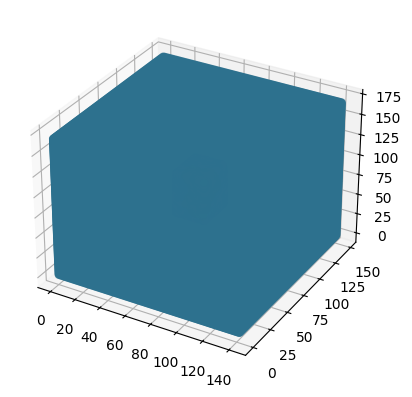

In [ ]:
depoMap, _ = mrc2padded(depoList[-1], apix)

In [ ]:

# 输入为torch张量batch_size*60*60*60
model = SCUNet(
    in_nc=1,
    config=[2,2,2,2,2,2,2],
    dim=32,
    drop_path_rate=0.0,
    input_resolution=48,
    head_dim=16,
    window_size=3,
)
torch.cuda.empty_cache()
model = model.cuda()
print(model)

# 定义损失函数
def loss(pred, target):
    smooth_l1_loss = nn.SmoothL1Loss(beta=1.0, reduction='mean')
    return smooth_l1_loss(pred, target) + 1 - ssim(pred, target, data_range=1.0,    size_average=True)
    

# 定义trainer
trainer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    amsgrad=False
)



In [ ]:
model.train()
for depoFile, simuFile in zip(depoList, simuList):
    if(os.path.getsize(depoFile) > 1024 * 1024 * 512 or os.path.getsize(simuFile) > 1024 * 1024 * 512):
        continue
    depoPadded, depoMax = mrc2padded(depoFile, 1.0)
    simuPadded, simuMax = mrc2padded(simuFile, 1.0)
    depoShape = depoPadded.shape
    simuShape = simuPadded.shape
    #两个map不一样大，如何align，同时生成一样大的且对应的map
    for epoch in range(num_epochs):
        train_loss = 0
        depo_generator = chunk_generator(depoPadded, depoMax, 60, 30)
        simu_generator = chunk_generator(simuPadded, simuMax, 60, 30)
        while True:
            positions_depo, depo_chunks = get_batch_from_generator(depo_generator, batch_size, dtype=np.float32)
            positions_simu, simu_chunks = get_batch_from_generator(simu_generator, batch_size, dtype=np.float32)
            if depo_chunks.shape != simu_chunks.shape:
                continue
            
            if depo_chunks.shape[0] == 0:
                break
            depo_chunks = torch.from_numpy(depo_chunks).float()
            simu_chunks = torch.from_numpy(simu_chunks).float()
            #保证depo和simu这俩map对每个chunk的操作完全一致，即密度能完全对应上
            depo_chunks = transform(depo_chunks)
            simu_chunks = transform(simu_chunks)
            X = V(FT(depo_chunks), requires_grad=True).view(-1, 1, 48, 48, 48)
            X = X.cuda()
            simu_chunks = simu_chunks.cuda()
            y_pred = model(X).view(-1, 48, 48, 48)           
            l = loss(y_pred, simu_chunks)
            trainer.zero_grad()
            l.backward()
            trainer.step()
            train_loss += l
            print(f"depo: {positions_depo} / {depoShape}")
            print(f"simu: {positions_simu} / {simuShape}")
        print(f"epoch:{epoch} depofile:{depoFile} train_loss:{train_loss}")